In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import numba
import eqtk
import pandas as pd
from matplotlib.colors import LogNorm
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

# # For interactive plots
# import ipywidgets

# Import plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
# Set matplotlib rc params.
rc = {'lines.linewidth' : 2, 'axes.labelsize' : 20, 'legend.fontsize': 12,
        'axes.titlesize' : 25, 'xtick.labelsize': 15, 'ytick.labelsize': 15}

sns.set(rc=rc)
sns.set_style("whitegrid")

%load_ext blackcellmagic
%matplotlib inline

Loading BokehJS ...

In [2]:
def assess_steady_state_convergence(RLN, interval, convergence_crit):
    """Determines whether the system has reached
    steady-state."""
    
    converged = True
    
    # Compute gradient across last hour and compute percent difference
    
    back_idx = int(60 / interval + 1)
    
    # initialize
    (R_err, L_err, N_err) = (0.0, 0.0, 0.0)
    
    # Replace values while avoiding divide by zero errors
    # Multiply by 100 to get percent difference
    if RLN[-1,0] != 0:
        R_err = 100 * abs(RLN[-1,0] - RLN[-back_idx,0]) / RLN[-1,0]
    if RLN[-1,1] != 0:
        L1_err = 100 * abs(RLN[-1,1] - RLN[-back_idx,1]) / RLN[-1,1]
    if RLN[-1,2] != 0:
        L2_err = 100 * abs(RLN[-1,2] - RLN[-back_idx,2]) / RLN[-1,2]
    
    RLN_err = np.array((R_err, L_err, N_err))
    
    # Evaluate convergence   
    failed_arr = RLN_err > convergence_crit
    
    if np.sum(failed_arr) > 0:
#         print('The system has not reached steady state.')
        
        converged = False
        
    return converged

In [3]:
def solve_EQTK(c0_vect, stoich, K_vect):
    '''Takes in:
    - c0_vect = initial concentrations of all species in proper order
    - stoichiometric matrix
    - K_vect = list of Kd values in proper order '''

    N = stoich
    
    c = eqtk.solve(c0_vect, N, K_vect, units=None)
    
    R, Lt, Lc, C_plus, C_minus = c #all of the steady state concentrations after equilibrium is reached 
    
    # Sanity check of mass conservation:
    Rtot = c0_vect[0]
         
    return c

In [4]:
def plot_dynamics(t, y_vals, normalized=False, 
                  normalize_to_max=True, leg_loc='center right', 
                  leg_lab = ('Total receptor','Total ligand',
                             'Activated receptor','Trans R:L complex'),
                  xlab = 'time (hr)', ylim = False,
                  ylab = 'dimensionless conc.', title = '',
                 filesave = 'NA'):
    """Convenient plotting function for results"""
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    # Get plot of stimulus dynamics

    if normalized:
        ylab = 'normalized ' + ylab
        if normalize_to_max:
            ax = plt.plot(t, y_vals[:,0]/y_vals[:,0].max())
            ax = plt.plot(t, y_vals[:,1]/y_vals[:,1].max())
            ax = plt.plot(t, y_vals[:,2]/y_vals[:,2].max())
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[:,3].max())
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[:,4].max())

        else:
            ax = plt.plot(t, y_vals[:,0]/y_vals[-1,0])
            ax = plt.plot(t, y_vals[:,1]/y_vals[-1,1])
            ax = plt.plot(t, y_vals[:,2]/y_vals[-1,2])
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[-1,3])
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[-1,4])

    else:
        ax = plt.plot(t, y_vals[:,0])
        ax = plt.plot(t, y_vals[:,1])
        ax = plt.plot(t, y_vals[:,2])
        if np.shape(y_vals)[1] > 3:
            ax = plt.plot(t, y_vals[:,3])
        if np.shape(y_vals)[1] > 4:
            ax = plt.plot(t, y_vals[:,4])

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if ylim != False:
        plt.ylim(ylim)
    plt.legend(leg_lab,loc=leg_loc, fontsize = 14)
    plt.title(title, size=22)
    
    if filesave != 'NA':
        print('image saved.')
        filename =  '/Users/catherineko/Desktop/FSRI/Research/temp/' + filesave +  '.pdf'
        plt.savefig(filename, bbox_inches='tight', format='pdf')
    
    return ax

In [5]:
def get_steady_state_vals(RLN, interval, convergence_crit):
    '''Extracts steady-state values from end
    of simulation and reports percent difference 
    across last hour of simulation to assist 
    evaluation of whether steady-state was reached.
    Convergence criterion is the maximum percent
    difference allowed before we say the system has 
    reached steady-state. E.g. 1 for one percent.'''
    
    # Compute steady state vals
    
    R0 = RLN[-1,0]
    L0 = RLN[-1,1]
    N0 = RLN[-1,2]
    
    RLN0 = np.array((R0, L0, N0)) 
    
    # Determine whether system has reached steady-state
    
    converged = assess_steady_state_convergence(RLN, interval, convergence_crit)
    
    if converged:
        return RLN0
    else:
        return np.array((np.nan, np.nan, np.nan))

In [6]:
def concat_initial_value(RLN, RLN_initial, hr, tpts):
    """Adds on initial value to simulation output
    in order to see how 'mixing' senders and receivers
    altered receptor and ligand levels.
    Can take RLN or RLNT of any shape as long as the
    dimensions of RLN and RLN_initial are compatible."""
    
    # concat on initial values
    RLN = np.concatenate((RLN_initial, RLN), axis = 0)
    
    # update t accordingly:
    t = np.linspace(0, hr + (hr/tpts), tpts+1)
    
    return RLN, t

In [7]:
def compute_cis_activation_potency(N_vect): #peak over leaky 
    '''This function returns the peak activation
    over leaky activation (latter assumed to be first 
    N-value).'''
    
    return np.around(np.max(N_vect) / N_vect[0], decimals = 2)

def compute_cis_inhibition_potency(N_vect):#??? metric of cis inhibition
    '''This function returns the inhibitory potential,
    defined as how close to 'leaky' activation the inhibitory
    ligand dampens the signal.
    This is expressed as a fraction, where 1 is the maximal
    inhibition possible, and 0 = no inhibition.'''
    
    # (peak activation - activation at highest cis ligand level) / 
    # (peak activation - leaky activation)
    
    cis_inh = 100 * (np.max(N_vect) - N_vect[-1]) / (np.max(N_vect) - N_vect[0])
    
    return np.around(cis_inh, decimals = 2)


In [8]:
def titrate_ligand(aL_vect, params, hr, interval, convergence_crit):
    '''This runs a series of simulations to calculate
    steady-state N (NICD) values for a range of ligand 
    levels.
    aL_vect is the range of ligand values to explore'''
    
    N_vect = []
    
    for aL in aL_vect:
        
        Kd_t, Kd_c, aR, gR, dR, gT, aL_prev, gL, gC, gN = params
        params = Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN
        
        # Simulate
        RLN_initial, RLN, t = simulate_Notch_signaling(params, hr, interval)
        
        # get steady state value
        RLN0 = get_steady_state_vals(RLN, interval, convergence_crit)
        N = RLN0[2]
        
        N_vect.append(N)
        
    # Determine cis-activation potency
    cis_act = compute_cis_activation_potency(N_vect)
    
    # Determine cis-inhibition potency???
    cis_inh = compute_cis_inhibition_potency(N_vect)
        
    return np.array(N_vect), cis_act, cis_inh
    

In [9]:
def logistic(x, max_Lt_frac, inflection_pt, curvature):
    """Returns y value of logistic function at 
    x value(s) provided based on three curve parameters."""

    return max_Lt_frac / (1 + np.exp(curvature * (x - inflection_pt)))

Text(0.5, 0, '$C^-$')

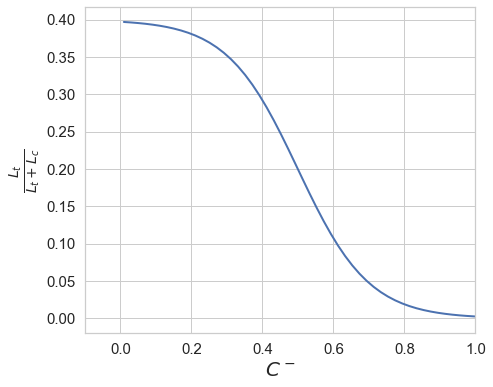

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# x = np.around(np.logspace(1.5, 3.4, num=100, base=10.0), decimals=4)
x = np.linspace(0.01,2, num=100)

inflection_pt = .5

plt.plot(x, logistic(x, .4, inflection_pt, 5 * (1/inflection_pt)))
# plt.xscale('log')
# plt.ylim(0,.42)
plt.xlim(-.1,inflection_pt * 2)
# plt.ylabel("$L_t$ / ($L_t$ + $L_c$)")
plt.ylabel("$\\frac{L_t}{L_t + L_c}$")
plt.xlabel("$C^-$")

In [11]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

In [12]:
#ODES
def dN_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of activated receptor (ICD); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return gT * C_p + dR * Rfree - gN * N


def dR_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface receptor (total receptor); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aR - gR * (R - C_m) - gC * C_m - gT * C_p - dR * Rfree


def dL_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface ligand (total ligand); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aL - gL * (Lt_free + Lc_free) - gR * C_p - gC * C_m - gT * C_p


In [13]:
def get_equilibrium_concentrations(R, Lt, Lc, circuit_params):
    """Gathers info needed to call EQTK
    and calls EQTK."""
    
    # Unpack params
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    
    # Stoichiometry matrix
    N_1_2 = [[1,  1,  0, -1,  0], #(1)R + (1)L_t + (0)L_c ⇌ (-1)C^+ + (0)C^-
         [1,  0,  1,  0, -1]] #(1)R + (0)L_t + (1)L_c ⇌ (0)C^+ + (-1)C^-
    
    # Array of Kd values
    K_vect = [Kd_t, Kd_c]

    # Initial concentration vector to pass to EQTK
    c0_vect = np.array((R, Lt, Lc, 0.0, 0.0)) # R_tot, Lt_tot, Lc_tot, C_plus, C_minus
    if np.isnan(c0_vect).any():
        print(c0_vect)
    neg = c0_vect[c0_vect < 0]
    if len(neg) > 0:
        print('negative found:', c0_vect)
        
    # Compute T based on R_tot and L_tot using EQTK
    Rfree, Lt_free, Lc_free, C_plus, C_minus = solve_EQTK(c0_vect, N_1_2, K_vect)
        
    return np.array([Rfree, Lt_free, Lc_free, C_plus, C_minus])

In [14]:
def Euler_integration(RLN_initial, circuit_params, dt, t_stop):    
    """
    Use Euler integration to solve ODEs
    for model of Notch cis interactions
    between one ligand and one receptor.
    """    

    # Time points
    t = np.linspace(0, t_stop, int(t_stop / dt) + 1)
    
    # Initialize output arrays
    R0, L0, N0 = RLN_initial
    #print('starting R, L, N at', R0, L0, N0)
    R = R0 * np.ones_like(t)
    L = L0 * np.ones_like(t)
    N = N0 * np.ones_like(t)
    C_minus = 0.0 * np.ones_like(t)
    
    # Do Euler stepping, preventing negative concentration values
    for i in range(0, len(t) - 1):
            
        # Compute fraction of ligand in 'trans-like' vs. 'cis-like' state
        # This must use prev value of C_minus, because current value is computed based on Lt, Lc
        Lt, Lc = populate_ligand_states(L[i], 0.0)
        if i > 0:
            Lt, Lc = populate_ligand_states(L[i], C_minus[i-1]) # Lt_tot, Lc_tot
        
        # Get equilibrium concentrations
        EQTK_output = get_equilibrium_concentrations(R[i], Lt, Lc, circuit_params)
        Rfree, Lt_free, Lc_free, C_p, C_m = EQTK_output # equilibrium concentrations at current step i
        
        # Add C_minus to array for CURRENT INDEX
        C_minus[i] = C_m
#         print('C_minus', C_m)
            
        # Compute new R
        R[i+1] = R[i] + dt * dR_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if R[i+1] < 0:
            R[i+1] = 0
        
        # Compute new L
        L[i+1] = L[i] + dt * dL_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if L[i+1] < 0:
            L[i+1] = 0
        
        # Compute new N
        N[i+1] = N[i] + dt * dN_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if N[i+1] < 0:
            N[i+1] = 0
        
    # Concatenate arrays
    #print('final C_minus = ', C_m)
    RLN = np.concatenate(([R,], [L,], [N,]), axis=0)
    RLN = np.transpose(RLN)
        
    return RLN, t


In [15]:
def simulate_Notch_signaling(circuit_params, hr, interval):
    """Runs Euler integration and returns 
    initial values (initial steady state) as 
    well as simulation output (with total receptor
    and ligand, not free) and time series.
    Takes as input one set of circuit parameters 
    and values that define the time series:
    - hr (simulation duration in hr) 
    - interval (time step in minutes)
    """
    
    # Define time series
    dt = interval / 60 # convert interval from minutes to hours
    
    # Start values at steady state
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    R0 = aR/(gR + dR)
    L0 = aL/gL
    N0 = dR * R0 / gN
    RLN_initial = (R0, L0, N0) 
    
    # Initiate Euler stepping
    RLN, t = Euler_integration(RLN_initial, circuit_params, dt, hr)

    # Return initial values and simulation output
    return RLN_initial, RLN, t

In [16]:
def significant_change(aL_vals, N_vect):
    """Creates array of 0,1,-1 values that represent no change, positive change, negative change respectively. 
    Used for peak_params to calculate whether a peak is occurring."""

    new_list = []

    for i, aL in enumerate(aL_vals):

        if i >0:
            change = N_vect[i] - N_vect[i-1]
            #print(N_vect[i],'-',N_vect[i-1],'=',change)
            if change > 0.05:
                #print(1)
                new_list.append(1)
            if change < -0.08:
                #print(-1)
                new_list.append(-1)
            if change <= 0.05 and change >= -0.1: 
                new_list.append(0)
                #print(0)

    new_array2 = np.array(new_list)

    return new_array2

In [17]:
def peak_params(aL_vals, N_vect):
    """Gives peak_width, start of peak, end of peak in terms of aL"""

    start_of_peak = np.nan
    end_of_peak = np.nan
    peak_width = np.nan

    for i, element in enumerate(significant_change(aL_vals, N_vect)):
        if element == 1:
            start_of_peak = aL_vals[i]
            break

    for i, element in reversed(list(enumerate(significant_change(aL_vals, N_vect)))):
        if element == -1:
            #if i+1==len(aL_vals):
            end_of_peak=aL_vals[i+1]
            #if i+1<len(significant_change(aL_vals)):
                #end_of_peak = aL_vals[i+1]
            break

    if start_of_peak != 0.0:
        peak_width = end_of_peak / start_of_peak  # beware of Nan

    return peak_width, start_of_peak, end_of_peak

# Plotting aR, Kd_t, and Kd_c by peak width

In [18]:
#Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_t = 1
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

# Dont run below cell unless reloading data

In [25]:
%%time 
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

master_array = np.array(())

for aR in aR_vals:
    for Kd_c in Kd_c_vals:

        # Define ligand range for titration- x axis for plot; adding ligands
        aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)
        aL_vals = np.insert(aL_vals, 0, 0)

        circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

        # Define time series
        hr = 48.0  # simulation of 48 hours
        interval = 5  # 5 minutes between time steps

        # ≤ 1 percent change in 5 minutes = steady state achieved
        convergence_crit = 1

        # Simulate ligand titration
        N_vect, cis_act, cis_inh = titrate_ligand(
            aL_vals, circuit_params, hr, interval, convergence_crit
        )

        # Added this in to quantify peak width
        peak_width, startpeak, endpeak = peak_params(aL_vals,N_vect)
        sig_change=significant_change(aL_vals,N_vect)

        Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params

        create_list = [
            Kd_t,
            Kd_c,
            aR,
            gR,
            dR,
            gT,
            aL_vals[0],
            gL,
            gC,
            gN,
            cis_act,
            cis_inh,
            startpeak,
            endpeak,
            peak_width,
            sig_change
        ]

        master_array = np.append(master_array, create_list)

CPU times: user 1min 21s, sys: 809 ms, total: 1min 21s
Wall time: 1min 26s


In [26]:
rows = master_array.size/16

In [27]:
master_array = master_array.reshape((int(rows),16))

In [28]:
masterdf = pd.DataFrame(master_array)

In [29]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'startpeak','endpeak','peak_width','sig_change']

In [30]:
masterdf.head()

Kd_t  Kd_c    aR        gR    dR      gT aL_vals[0]       gL        gC  \
0    1   0.1  0.05  0.866434  0.01  9.9021          0  2.31049  0.866434   
1    1  2.08  0.05  0.866434  0.01  9.9021          0  2.31049  0.866434   
2    1  4.06  0.05  0.866434  0.01  9.9021          0  2.31049  0.866434   
3    1  6.04  0.05  0.866434  0.01  9.9021          0  2.31049  0.866434   
4    1  8.02  0.05  0.866434  0.01  9.9021          0  2.31049  0.866434   

         gN cis_act cis_inh startpeak endpeak peak_width          sig_change  
0  0.554518   29.87    1.17       NaN     NaN        NaN  [0, 0, 0, 0, 0, 0]  
1  0.554518   75.77       0       NaN     NaN        NaN  [0, 0, 0, 0, 0, 0]  
2  0.554518   77.88       0       NaN     NaN        NaN  [0, 0, 0, 0, 0, 0]  
3  0.554518   78.63       0       NaN     NaN        NaN  [0, 0, 0, 0, 0, 0]  
4  0.554518   79.02       0       NaN     NaN        NaN  [0, 0, 0, 0, 0, 0]

In [31]:
filename = '/Users/catherineko/git/bootcamp/2020-08-11_Kd_t_1.csv'

masterdf.to_csv(filename, sep = ',', index=False)

### Read in data

In [32]:
file = '/Users/catherineko/git/bootcamp/2020-08-11_Kd_t_1.csv'
masterdf = pd.read_csv(file)

In [33]:
masterdf=masterdf.sort_values(by=['peak_width']).reset_index()

In [34]:
masterdf.head()

index  Kd_t  Kd_c    aR        gR    dR        gT  aL_vals[0]        gL  \
0     31     1  2.08  0.15  0.866434  0.01  9.902103         0.0  2.310491   
1      0     1  0.10  0.05  0.866434  0.01  9.902103         0.0  2.310491   
2      1     1  2.08  0.05  0.866434  0.01  9.902103         0.0  2.310491   
3      2     1  4.06  0.05  0.866434  0.01  9.902103         0.0  2.310491   
4      3     1  6.04  0.05  0.866434  0.01  9.902103         0.0  2.310491   

         gC        gN  cis_act  cis_inh  startpeak  endpeak  peak_width  \
0  0.866434  0.554518    72.74   101.32        0.1    100.0      1000.0   
1  0.866434  0.554518    29.87     1.17        NaN      NaN         NaN   
2  0.866434  0.554518    75.77     0.00        NaN      NaN         NaN   
3  0.866434  0.554518    77.88     0.00        NaN      NaN         NaN   
4  0.866434  0.554518    78.63     0.00        NaN      NaN         NaN   

            sig_change  
0  [ 0  0  0  1  1 -1]  
1        [0 0 0 0 0 0]  
2        [0 0 0 0 0 0]  
3        [0 0 0 0 0 0]  
4        [0 0 0 0 0 0]

In [35]:
no_nan_df= masterdf[masterdf['peak_width'].notna()]

%%black -l 49

In [36]:
for i,j in enumerate(masterdf.columns):
    if i <15:
        masterdf[str(j)]=pd.to_numeric(masterdf[str(j)])
masterdf.dtypes

index           int64
Kd_t            int64
Kd_c          float64
aR            float64
gR            float64
dR            float64
gT            float64
aL_vals[0]    float64
gL            float64
gC            float64
gN            float64
cis_act       float64
cis_inh       float64
startpeak     float64
endpeak       float64
peak_width    float64
sig_change     object
dtype: object

# Peak Width

In [50]:
def loopheatmaps(values,index,columns,loop,loopvals,startofloop=0,dataset=masterdf,vmin=None,vmax=None):
    """This function is for looping through creating a bunch of heat maps.
    values = what you want the color scale to represent STR
    index=y-axes STR
    columns=x-axis STR 
    loop= the variable staying constant that you are looping through for each map
    loopvals = ^ but the vals array
    startofloop = start of range; default = 0"""
    
    for i in range(startofloop,len(loopvals)):

        df_subset = dataset.loc[(dataset[str(loop)] == np.around(loopvals[i],decimals=4))]

        # I HAD A ROUNDING ERROR ^ BUT FIXED W NP.AROUND

        # I think dependence on aR == aL equivalence is only true for certain gR values. try gR = g_vals[3] vs [1]

        # pandas pivot
        heatmap_data = pd.pivot_table(df_subset, values=str(values), 
                             index=[str(index)], 
                             columns=str(columns))

        print('===============')
        print(str(loop),loopvals[i])
        sns.heatmap(heatmap_data,norm=LogNorm(),vmin=vmin,vmax=vmax)
        df_subset
        plt.show()
        plt.figure()
        
    

aR 0.09


/Users/cjko/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


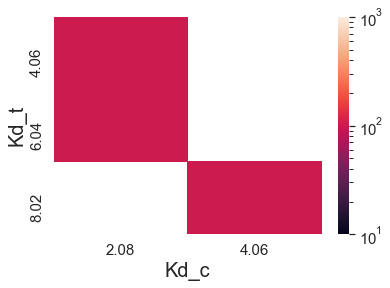

aR 0.11


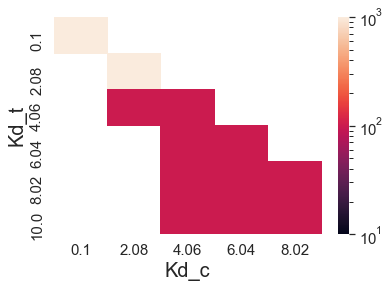

aR 0.13


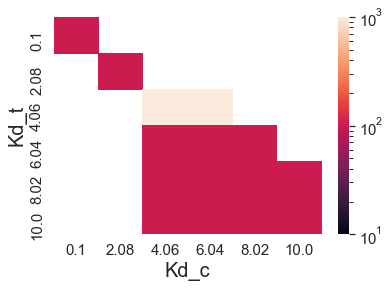

aR 0.15


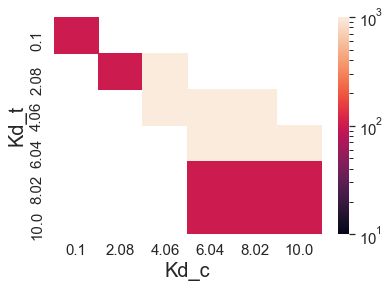

<Figure size 432x288 with 0 Axes>

In [51]:
loopheatmaps(
    values="peak_width",
    index="Kd_t",
    columns="Kd_c",
    loop="aR",
    loopvals=aR_vals,
    startofloop=2,
    vmin=10,
    vmax=1000
)

aR 0.05


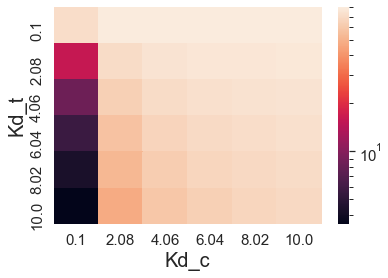

aR 0.07


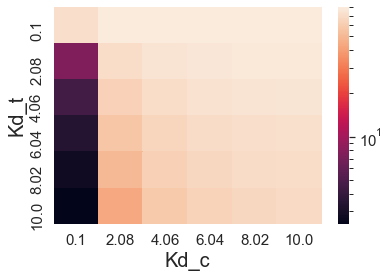

aR 0.09


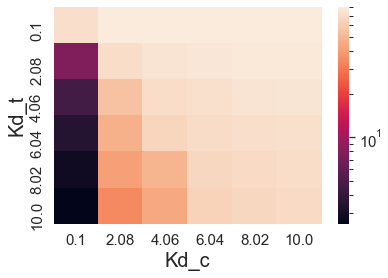

aR 0.11


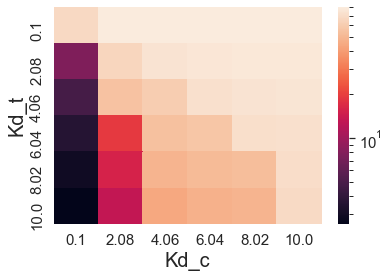

aR 0.13


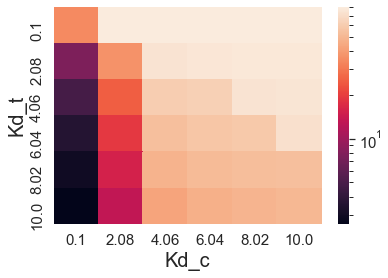

aR 0.15


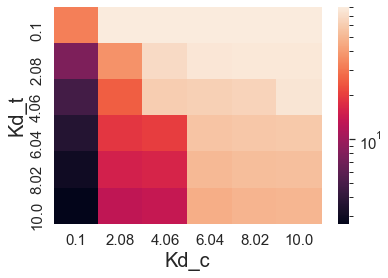

<Figure size 432x288 with 0 Axes>

In [52]:
loopheatmaps(
    values="cis_act",
    index="Kd_t",
    columns="Kd_c",
    loop="aR",
    loopvals=aR_vals,
    vmin=None,
    vmax=None,
    startofloop=0
)

aR 0.05


/Users/cjko/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/cjko/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


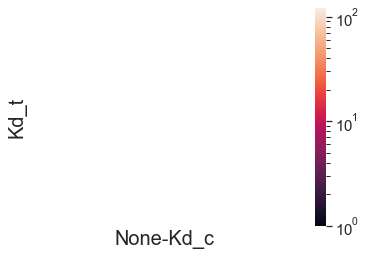

aR 0.07


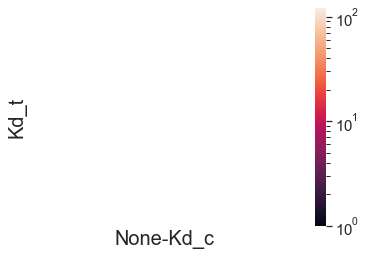

aR 0.09


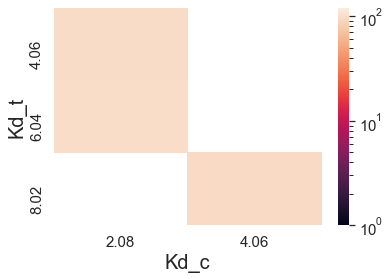

aR 0.11


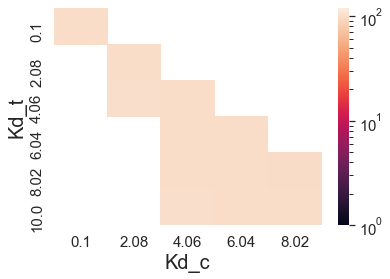

aR 0.13


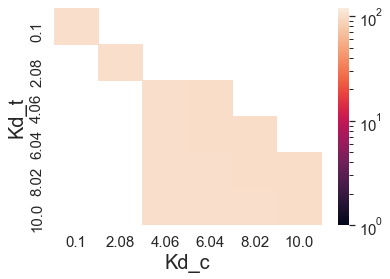

aR 0.15


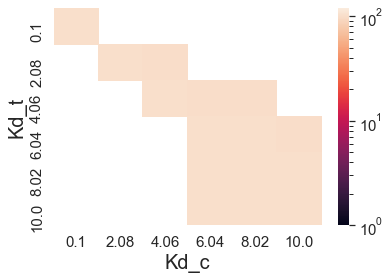

<Figure size 432x288 with 0 Axes>

In [53]:
loopheatmaps(
    values="cis_inh",
    index="Kd_t",
    columns="Kd_c",
    loop="aR",
    loopvals=aR_vals,
    vmin=1,
    vmax=120,
    dataset=no_nan_df
)

In [70]:
def plotter(Kd_t = 1,
    Kd_c = 0.1,
    aR = 0.11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4),
):
    """Kd_c = 0.1,
    aR = .11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)"""
    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0  # simulation of 48 hours
    interval = 5  # 5 minutes between time steps

    convergence_crit = 1  # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(
        aL_vals, circuit_params, hr, interval, convergence_crit
    )

    # Added this in to quantify peak width
    peak_width, startpeak, endpeak = peak_params(aL_vals, N_vect)
    
    # Print cis-activation and -inhibition metrics
#     for i, j in enumerate(circuit_params):
#         print(masterdf.columns[i+1], j)
#     print("Cis-activation fold-diff:", cis_act)
#     print("Cis-inhibition efficacy:", cis_inh, "%")
#     print("start of peak", startpeak)
#     print("end of peak", endpeak)
#     print("peak_width", peak_width)
#     print("sig change", significant_change(aL_vals, N_vect))

    p=bokeh.plotting.figure(
        frame_height=100,
        frame_width=200,
        x_axis_label="⍺L",
        y_axis_label="Steady state N",
        y_range=(0,.25),
        x_axis_type='log',
        title='Kd_c: '+str(Kd_c)+'; Kd_t: '+str(Kd_t)+'; aR: '+str(aR)
        
    )
    p.line(
        y=N_vect,
        x=aL_vals
    )
    return p
    #bokeh.io.show(p)
#     Plot
#     fig, ax = plt.subplots(1, 1, figsize=(7, 6))

#     plt.plot(aL_vals, N_vect)
#     plt.ylabel("Steady state $N$")
#     plt.xlabel("$\\alpha_L$")
#     plt.ylim((0, 1))
#     ax.set_xscale("log")
#     plt.show()


In [38]:
plotter()

Figure(id='1002', ...)

In [39]:
list_of_graphs = []


for Kd_c in Kd_c_vals:
    list_of_graphs.append(plotter(
        aR = 0.11,
        Kd_c=Kd_c))

In [40]:
bokeh.io.output_file("gridfrom_constant_kd_t_1.html")
bokeh.io.show(bokeh.layouts.gridplot(list_of_graphs, ncols=6))
# bokeh.io.save(
#     plotter(),
#     filename='gridplots.html',
#     title='Grid plots'
# )


In [71]:
list_of_graphs = []

for aR in aR_vals:
    list_of_graphs.append(plotter(aR=aR,Kd_t=1,
        Kd_c=1))

In [72]:
bokeh.io.output_file("gridfrom_constant_Kd_t_Kd_c_1.html")
bokeh.io.show(bokeh.layouts.gridplot(list_of_graphs, ncols=6))
# bokeh.io.save(
#     plotter(),
#     filename='gridplots.html',
#     title='Grid plots'
# )


# Slider

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
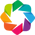

In [42]:
import holoviews as hv
import panel as pn
pn.extension()

hv.extension('bokeh')

In [46]:
Kd_c_slider = pn.widgets.FloatSlider(
    name="Kd_c", start=0.1, end=10.0, step=1.98, value=10.0
)

aR_slider = pn.widgets.FloatSlider(
    name="aR", start=0.05, end=0.15, step=0.02, value=0.11
)

@pn.depends(Kd_c_slider.param.value, aR_slider.param.value)
def plotter(
    Kd_c = 0.1,
    aR = 0.11,
    Kd_t = 1.0,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4),
):
    """Kd_c = 0.1,
    aR = .11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)"""
    
    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0  # simulation of 48 hours
    interval = 5  # 5 minutes between time steps

    convergence_crit = 1  # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(
        aL_vals, circuit_params, hr, interval, convergence_crit
    )

    # Added this in to quantify peak width
    peak_width, startpeak, endpeak = peak_params(aL_vals, N_vect)
    
    #Print cis-activation and -inhibition metrics
#     for i, j in enumerate(circuit_params):
#         print(str(masterdf.columns[i+1]) + ': '+str(j))
#     print("Cis-activation fold-diff:", cis_act)
#     print("Cis-inhibition efficacy:", cis_inh, "%")
#     print("start of peak", startpeak)
#     print("end of peak", endpeak)
#     print("peak_width", peak_width)
#     print("sig change", significant_change(aL_vals, N_vect))

    p=bokeh.plotting.figure(
        frame_height=250,
        frame_width=400,
        x_axis_label="⍺L",
        y_axis_label="Steady state N",
        y_range=(0,.25),
        x_axis_type='log',
        title='Kd_c: '+str(Kd_c)+'; Kd_t: '+str(Kd_t)+'; aR: '+str(aR)
        
    )
    p.line(
        y=N_vect,
        x=aL_vals
    )
    return p

widgets = pn.Column(
    pn.Spacer(height=30),
    Kd_c_slider,
    pn.Spacer(height=15),
    aR_slider,
    pn.Spacer(height=15),
    width=200
)
pn.Row(plotter, pn.Spacer(width=15), widgets)

# source = bokeh.models.ColumnDataSource(
#     data=dict(y=N_vect,x=aL_vals)

# # Callback (uses JavaScript)
# js_code = """
# // Extract data from source and sliders
# var x_x = source.data['x_x'];
# var x_y = source.data['x_y'];
# var y_x = source.data['y_x'];
# var y_y = source.data['y_y'];
# var beta_x = beta_x_slider.value;
# var beta_y = beta_y_slider.value;
# var n = n_slider.value

# // Update nullclines
# for (var i = 0; i < x_y.length; i++) {
#     x_x[i] = beta_x / (1 + Math.pow(y_x[i], n));
#     y_y[i] = beta_y / (1 + Math.pow(x_y[i], n));
# }

# // Emit changes
# source.change.emit();
# """
# callback = bokeh.models.CustomJS(args=dict(source=source), code=js_code)

# # We use the `js_on_change()` method to call the custom JavaScript code.
# for param, slider in zip(params, sliders):
#     callback.args[param["long_name"]] = slider
#     slider.js_on_change("value", callback)

# bokeh.io.show(bokeh.layouts.column(bokeh.layouts.column(sliders), p))

# bokeh.io.output_file("slider_kds_aR.html")
# bokeh.io.show(pn.Row(plotter, pn.Spacer(width=15), widgets))

Row
    [0] ParamFunction(function)
    [1] Spacer(width=15)
    [2] Column(width=200)
        [0] Spacer(height=30)
        [1] FloatSlider(end=10.0, name='Kd_c', start=0.1, step=1.98, value=10.0)
        [2] Spacer(height=15)
        [3] FloatSlider(end=0.15, name='aR', start=0.05, step=0.02, value=0.11)
        [4] Spacer(height=15)

In [63]:
def plotter(
    aR = 0.11,
    Kd_c = 1.0,
    Kd_t = 1.0,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4),
):
    """Kd_c = 0.1,
    aR = .11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)"""
    
    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0  # simulation of 48 hours
    interval = 5  # 5 minutes between time steps

    convergence_crit = 1  # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(
        aL_vals, circuit_params, hr, interval, convergence_crit
    )

    # Added this in to quantify peak width
    peak_width, startpeak, endpeak = peak_params(aL_vals, N_vect)

    return N_vect, aL_vals, Kd_c, Kd_t

params = [
    dict(
        name = 'aR',
        start = 0.05,
        end=0.15,
        step=0.02,
        value=0.11,
        long_name = 'aR_slider',
    )
]

sliders = [
    bokeh.models.Slider(
        start=param["start"],
        end=param["end"],
        value=param["value"],
        step=param["step"],
        title=param["name"],
    )
    for param in params
]

#build base plot with starting parameters
aR = 0.11

#Compute
N_vect, aL_vals, Kd_c, Kd_t = plotter(aR=aR)

source = bokeh.models.ColumnDataSource(
    data=dict(N_vect=N_vect,aL_vals=aL_vals)
)


# Make the plot
p=bokeh.plotting.figure(
    frame_height=250,
    frame_width=400,
    x_axis_label="⍺L",
    y_axis_label="Steady state N",
    y_range=(0,.25),
    x_axis_type='log',
    title='Kd_c: '+str(Kd_c)+'; Kd_t: '+str(Kd_t)+'; aR: '+str(aR)

)
p.line(
    y="N_vect",
    x="aL_vals",
    source=source
)

# Callback (uses Javascript)
js_code = """
// Extract data from source and sliders
var aL_vals = source.data['aL_vals'];
var N_vect = source.data['N_vect'];
var aR = aR_slider.value

// Update 
plotter(aR=aR)
}

// Emit changes
source.change.emit();
"""
callback = bokeh.models.CustomJS(args=dict(source=source), code=js_code)

# We use the `js_on_change()` method to call the custom JavaScript code.
for param, slider in zip(params, sliders):
    callback.args[param["long_name"]] = slider
    slider.js_on_change("value", callback)

bokeh.io.show(bokeh.layouts.column(bokeh.layouts.column(sliders), p))


In [65]:
# Set up sliders
params = [
    dict(
        name="βx",
        start=0.1,
        end=20,
        step=0.1,
        value=10,
        long_name="beta_x_slider",
    ),
    dict(
        name="βy",
        start=0.1,
        end=20,
        step=0.1,
        value=10,
        long_name="beta_y_slider",
    ),
    dict(name="n", start=1, end=10, step=0.1, value=4, long_name="n_slider"),
]
sliders = [
    bokeh.models.Slider(
        start=param["start"],
        end=param["end"],
        value=param["value"],
        step=param["step"],
        title=param["name"],
    )
    for param in params
]

# Build base plot with starting parameters
beta = 10
n = 4

# Compute nullclines
x_y = np.linspace(0, 20, 400)
y_x = np.linspace(0, 20, 400)
x_x = beta / (1 + y_x ** n)
y_y = beta / (1 + x_y ** n)

source = bokeh.models.ColumnDataSource(
    data=dict(x_x=x_x, x_y=x_y, y_x=y_x, y_y=y_y)
)

# Make the plot
p = bokeh.plotting.figure(
    frame_height=275, frame_width=375, x_axis_label="x", y_axis_label="y"
)
p.line(
    x="x_x", y="y_x", source=source, line_width=2, legend_label="x nullcline"
)
p.line(
    x="x_y",
    y="y_y",
    source=source,
    line_width=2,
    color="orange",
    legend_label="y nullcline",
)

# Callback (uses JavaScript)
js_code = """
// Extract data from source and sliders
var x_x = source.data['x_x'];
var x_y = source.data['x_y'];
var y_x = source.data['y_x'];
var y_y = source.data['y_y'];
var beta_x = beta_x_slider.value;
var beta_y = beta_y_slider.value;
var n = n_slider.value

// Update nullclines
for (var i = 0; i < x_y.length; i++) {
    x_x[i] = beta_x / (1 + Math.pow(y_x[i], n));
    y_y[i] = beta_y / (1 + Math.pow(x_y[i], n));
    x_x[i]
}

// Emit changes
source.change.emit();
"""
callback = bokeh.models.CustomJS(args=dict(source=source), code=js_code)

# We use the `js_on_change()` method to call the custom JavaScript code.
for param, slider in zip(params, sliders):
    callback.args[param["long_name"]] = slider
    slider.js_on_change("value", callback)

bokeh.io.show(bokeh.layouts.column(bokeh.layouts.column(sliders), p))


In [53]:
Kd_c

10.0

In [50]:
def plotter(
    aR = 0.11,
    Kd_c = 1.0,
    Kd_t = 1.0,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4),
):
    """Kd_c = 0.1,
    aR = .11,
    gR = np.log(2) / .8,
    dR = 0.01,
    gT = np.log(2) / .07,
    gC = np.log(2)/.8,
    gL = np.log(2) / .3,
    gN = np.log(2) / 1.25,
    aL_vals = np.around(np.logspace(-3, 2, num=6, base=10.0), decimals=4)"""
    
    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0  # simulation of 48 hours
    interval = 5  # 5 minutes between time steps

    convergence_crit = 1  # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(
        aL_vals, circuit_params, hr, interval, convergence_crit
    )

    # Added this in to quantify peak width
    peak_width, startpeak, endpeak = peak_params(aL_vals, N_vect)
    
    return N_vect, aL_vals

In [51]:
plotter()

(array([0.00256437, 0.00523285, 0.02834292, 0.11183009, 0.15537068,
        0.00060922]),
 array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]))